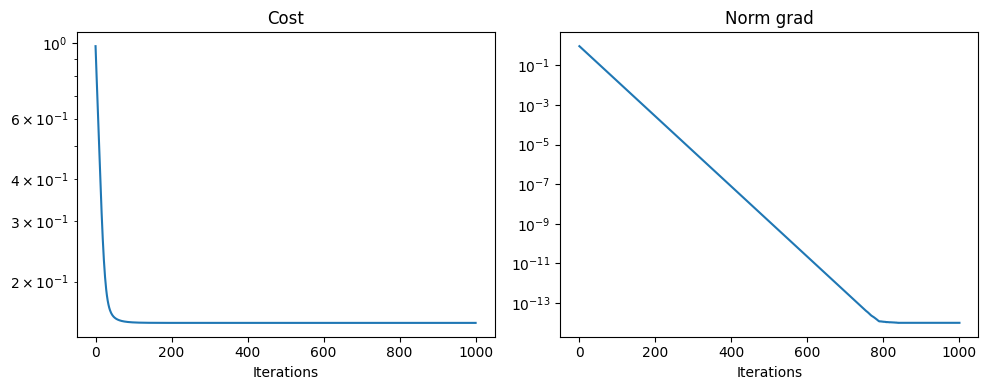

In [51]:
import numpy as np
from Function import LossFunctionTask2
from utils import generate_adj_matrix
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def plot_scenario(
    robots_pos: np.ndarray, private_targets: np.ndarray, old_robots_pos=None
):
    colors = [
        "tab:orange",
        "tab:purple",
        "tab:green",
        "tab:blue",
        "tab:cyan",
        "tab:red",
    ]
    barycenter = np.mean(robots_pos, axis=0)
    plt.plot(
        barycenter[0],
        barycenter[1],
        "s",
        color="tab:blue",
        label="Barycenter",
        markersize=20,
        alpha=0.75,
    )
    for i in range(len(robots_pos)):
        plt.plot(
            robots_pos[i][0],
            robots_pos[i][1],
            "o",
            color=colors[i % len(colors)],
            markersize=12,
        )

        # Draw small lines segment from robot to barycenter
        plt.plot(
            [robots_pos[i][0], barycenter[0]],
            [robots_pos[i][1], barycenter[1]],
            color=colors[i % len(colors)],
            linestyle="dashdot",
            alpha=0.2,
        )

    for i in range(len(private_targets)):
        plt.plot(
            private_targets[i][0],
            private_targets[i][1],
            "X",
            color=colors[i % len(colors)],
            label=f"Target {i}",
            markersize=8,
            alpha=0.75,
        )

    if old_robots_pos is not None:
        # Trace the path of the robots
        for i in range(len(robots_pos)):
            plt.plot(
                [old_robots_pos[j][i][0] for j in range(len(old_robots_pos))],
                [old_robots_pos[j][i][1] for j in range(len(old_robots_pos))],
                color=colors[i % len(colors)],
                linestyle="--",
                alpha=0.5,
            )

#############################
# PARAMETERS
#############################

NUM_ROBOTS = 3
VAR_DIMS = 2
SEED = 42
NUM_ITERATIONS = 1000
ALPHA = lambda k: 2e-2
GAMMAS = [0.4] * NUM_ROBOTS

rng = np.random.default_rng(SEED)

#############################
# PROBLEM SETUP
#############################

private_targets = rng.random(size=(NUM_ROBOTS, VAR_DIMS))
loss_functions = [
    LossFunctionTask2(private_targets[i], GAMMAS[i]) for i in range(NUM_ROBOTS)
]
robot_initial_positions = rng.random(size=(NUM_ROBOTS, VAR_DIMS))

G, A = generate_adj_matrix(
    NUM_ROBOTS,
    connected=True,
    seed=SEED,
    graph_algorithm="erdos_renyi",
    erdos_renyi_p=0.3,
)

def phi(x):
    return x


def grad_phi(x):
    return np.ones(x.shape[0])


def gradient_tracking_aggregative(
    fn_list: list[LossFunctionTask2],
    z0: np.ndarray,
    A: np.ndarray,
    alpha: callable,
    num_iters: int,
    num_agents: int,
    phi: callable = phi,
    grad_phi: callable = grad_phi,
    return_s_v: bool = False,
):
    z = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    s = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    v = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))

    z[0] = z0
    s[0] = phi(z0)
    for i in range(num_agents):
        v[0] = fn_list[i].grad_sigma_z(z[0][i], s[0][i])

    for k in range(num_iters):
        for i in range(num_agents):
            neighbors = np.nonzero(A[i])[0]

            z[k + 1, i] = z[k, i] - alpha(k) * (
                fn_list[i].grad_z(z[k, i], s[k, i]) + v[k, i] * grad_phi(z[k, i])
            )
            s[k + 1, i] = sum(A[i, j] * s[k, j] for j in neighbors) + (
                phi(z[k + 1, i]) - phi(z[k, i])
            )
            v[k + 1, i] = sum(A[i, j] * v[k, j] for j in neighbors) + (
                fn_list[i].grad_sigma_z(z[k + 1, i], s[k + 1, i])
                - fn_list[i].grad_sigma_z(z[k, i], s[k, i])
            )

    if return_s_v:
        return z, s, v
    else:
        return z

z_history,s_history, v_history  = gradient_tracking_aggregative(
    fn_list=loss_functions,
    z0=robot_initial_positions.copy(),
    A=A,
    num_iters=NUM_ITERATIONS,
    alpha=ALPHA,
    return_s_v=True,
    num_agents=NUM_ROBOTS,
)

cost_history = [
    sum([loss_functions[i](z_i, np.mean(z)) for i, z_i in enumerate(z)])
    for z in z_history
]

grad_cost_history = np.array([
    [(
        loss_functions[i].grad_z(z[i], s[i]) + v[i] * grad_phi(z[i])
    ) 
    for i in range(NUM_ROBOTS)]
    for z,v,s in zip(z_history, v_history, s_history)
])
grad_cost_history_sum = np.linalg.norm(np.sum(grad_cost_history, axis=1), axis=1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Cost")
plt.plot(cost_history)
plt.xlabel("Iterations")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.title("Norm grad")
plt.plot(grad_cost_history_sum)
plt.xlabel("Iterations")
plt.yscale("log")
plt.tight_layout()
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


TypeError: AbstractMovieWriter.__init__() got an unexpected keyword argument 'extra_args'

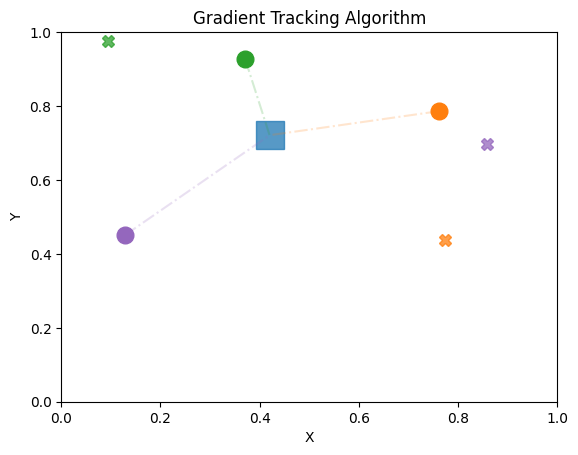

In [52]:
from IPython.display import HTML
# Create an animation, by showing the scenario at each iteration
def animate_scenario(z_history, private_targets, frames):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title("Gradient Tracking Algorithm")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # frames = range(0, 200, skip)

    def update(frame_idx):
        ax.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("Gradient Tracking Algorithm")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plot_scenario(z_history[frames[frame_idx]], private_targets, z_history[:frames[frame_idx] + 1])
        return (ax,)

    ani = FuncAnimation(fig, update, frames=len(frames), blit=False, interval=200)

    # Fix: Display the animation
    display(HTML(ani.to_jshtml()))

    # Save the animation as a video file
    ani.save("gradient_tracking_animation.mp4", fps=10, extra_args=["-vcodec", "libx264"])
    # plt.show()

animate_scenario(z_history, private_targets, frames=range(0, 300, 10))

# Idea
Maybe, regardless of the value of gamma, tge barycenter of the group always converges to the barycenter of the targets.

In [32]:
import numpy as np
from Function import LossFunctionTask2, LossFunctionTask2_MaxDistance, Function
from utils import generate_adj_matrix
import matplotlib.pyplot as plt

In [33]:
class LossFunctionTask2Adaptive(Function):
    def __init__(self, private_target: np.ndarray, gamma: float, max_distance: float):
        self.private_target = private_target
        self.gamma = gamma
        self.max_distance = max_distance

    def weight(self, z: np.ndarray) -> float:
        d = np.linalg.norm(z - self.private_target)
        return 1.0 / (1.0 + np.exp(-10 * (self.max_distance - d)))

    def __call__(self, z: np.ndarray, sigma_z: np.ndarray) -> np.ndarray:
        target_loss = np.linalg.norm(z - self.private_target) ** 2
        team_loss = np.linalg.norm(z - sigma_z) ** 2

        w = self.weight(z)  

        return target_loss + self.gamma * w * team_loss

    def grad_z(self, z: np.ndarray, sigma_z: np.ndarray) -> np.ndarray:
        d = np.linalg.norm(z - self.private_target)
        w = self.weight(z)

        target_grad = 2 * (z - self.private_target)
        team_grad = 2 * (z - sigma_z)
        return target_grad + self.gamma * w * team_grad

    def grad_sigma_z(self, z: np.ndarray, sigma_z: np.ndarray) -> np.ndarray:
        w = self.weight(z)
        return -2 * self.gamma * w * (z - sigma_z)

    def grad(self, z: np.ndarray, sigma_z: np.ndarray) -> np.ndarray:
        grad_z = self.grad_z(z, sigma_z)
        grad_sigma_z = self.grad_sigma_z(z, sigma_z)
        return np.concatenate((grad_z, grad_sigma_z), axis=0)


In [53]:
NUM_ROBOTS = 3
VAR_DIMS = 2
SEED = 42
NUM_ITERATIONS = 5000
ALPHA = lambda k: 2e-3
GAMMAS = [0.9] * NUM_ROBOTS

rng = np.random.default_rng(SEED)

In [61]:
private_targets = rng.random(size=(NUM_ROBOTS, VAR_DIMS))
max_distances = 0.000000000001
#loss_functions = [
#    LossFunctionTask2(private_targets[i], GAMMAS[i]) for i in range(NUM_ROBOTS)
#]
#loss_functions = [
#    LossFunctionTask2_MaxDistance(private_targets[i], max_distances) for i in range(NUM_ROBOTS)
#]
loss_functions = [
    LossFunctionTask2Adaptive(private_target=private_targets[i], gamma=GAMMAS[i], max_distance=max_distances) for i in range(NUM_ROBOTS)
    
]
robot_initial_positions = rng.random(size=(NUM_ROBOTS, VAR_DIMS))

def phi(x):
    return x

def grad_phi(x):
    return np.ones(x.shape[0])

def gradient_tracking_aggregative(
    fn_list: list[LossFunctionTask2_MaxDistance],
    z0: np.ndarray,
    A: np.ndarray,
    alpha: callable,
    num_iters: int,
    num_agents: int,
    phi: callable = phi,
    grad_phi: callable = grad_phi,
    return_s_v: bool = False,
):
    z = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    s = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))
    v = np.zeros((num_iters + 1, z0.shape[0], z0.shape[1]))

    z[0] = z0
    s[0] = phi(z0)
    for i in range(num_agents):
        v[0] = fn_list[i].grad_sigma_z(z[0][i], s[0][i])

    for k in range(num_iters):
        for i in range(num_agents):
            neighbors = np.nonzero(A[i])[0]

            z[k + 1, i] = z[k, i] - alpha(k) * (
                fn_list[i].grad_z(z[k, i], s[k, i]) + v[k, i] * grad_phi(z[k, i])
            )
            s[k + 1, i] = sum(A[i, j] * s[k, j] for j in neighbors) + (
                phi(z[k + 1, i]) - phi(z[k, i])
            )
            v[k + 1, i] = sum(A[i, j] * v[k, j] for j in neighbors) + (
                fn_list[i].grad_sigma_z(z[k + 1, i], s[k + 1, i])
                - fn_list[i].grad_sigma_z(z[k, i], s[k, i])
            )

    if return_s_v:
        return z, s, v
    else:
        return z

G, A = generate_adj_matrix(
    NUM_ROBOTS,
    connected=True,
    seed=SEED,
    graph_algorithm="erdos_renyi",
    erdos_renyi_p=0.3,
)

z_history,s_history, v_history  = gradient_tracking_aggregative(
    fn_list=loss_functions,
    z0=robot_initial_positions.copy(),
    A=A,
    num_iters=NUM_ITERATIONS,
    alpha=ALPHA,
    return_s_v=True,
    num_agents=NUM_ROBOTS,
)

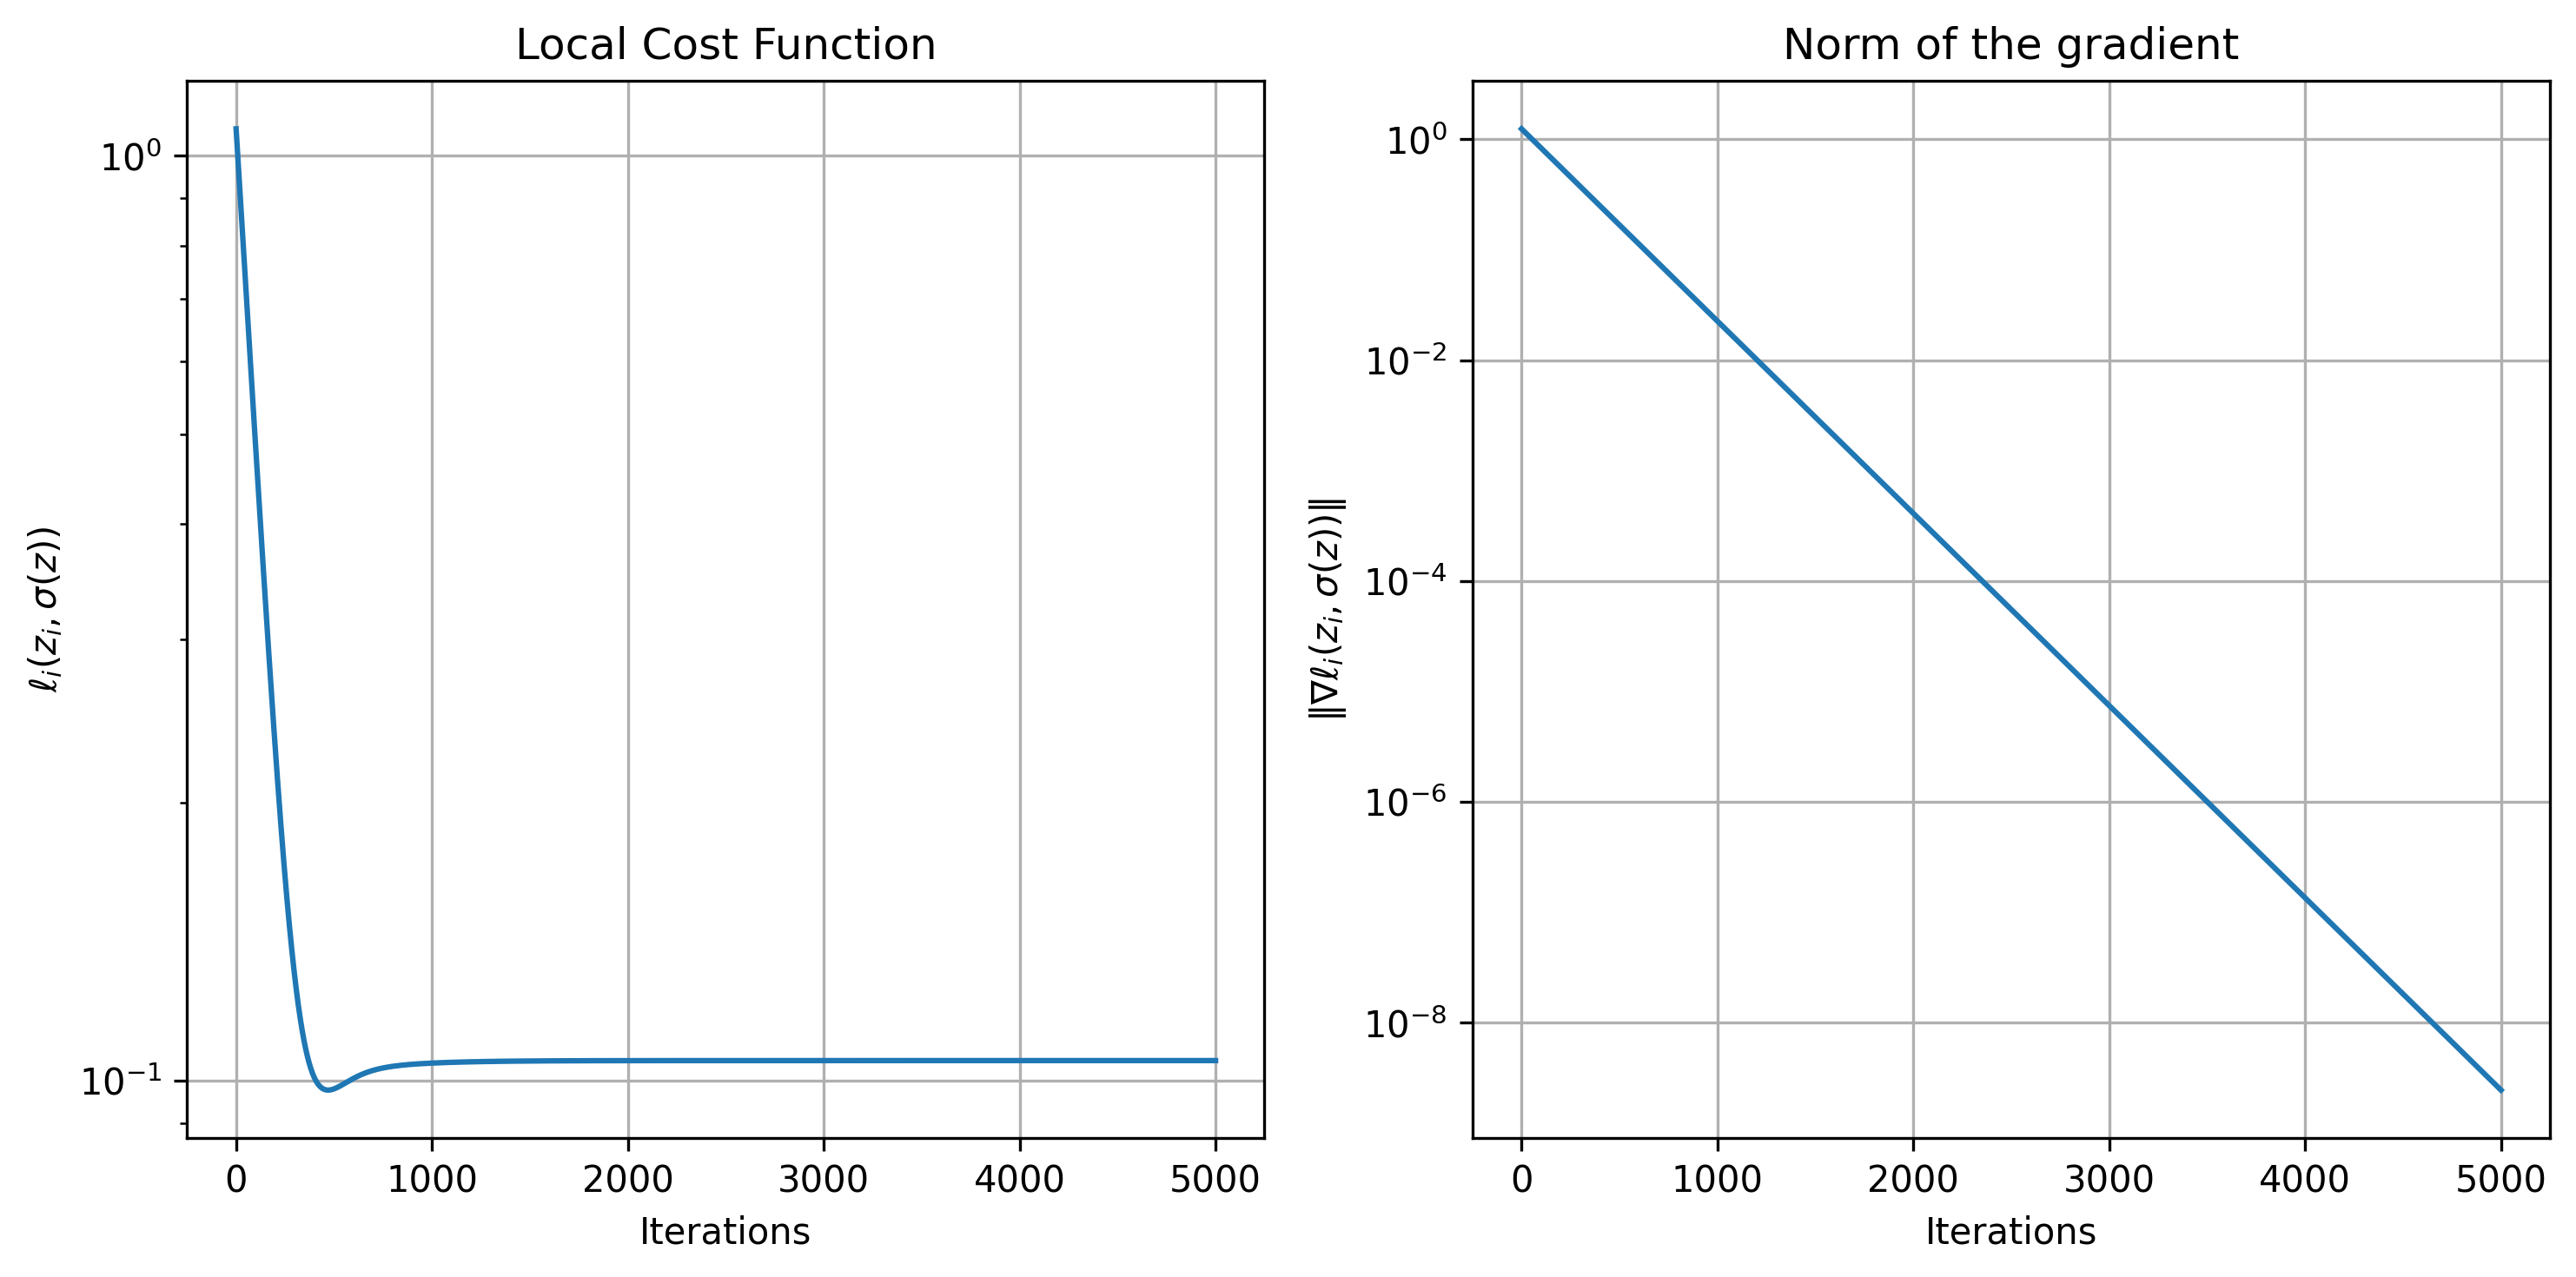

In [62]:
cost_history = [
    sum([loss_functions[i](z_i, np.mean(z)) for i, z_i in enumerate(z)])
    for z in z_history
]

grad_cost_history = np.array([
    [(
        loss_functions[i].grad_z(z[i], s[i]) + v[i] * grad_phi(z[i])
    ) 
    for i in range(NUM_ROBOTS)]
    for z,v,s in zip(z_history, v_history, s_history)
])
grad_cost_history_sum = np.linalg.norm(np.sum(grad_cost_history, axis=1), axis=1)

plt.figure(figsize=(10, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.title('Local Cost Function')
plt.plot(cost_history)
plt.xlabel("Iterations")
plt.ylabel(r'$\ell_i(z_i, \sigma(z))$')
plt.grid()
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.title('Norm of the gradient')
plt.plot(grad_cost_history_sum)
plt.ylabel(r"$\|\nabla \ell_i(z_i, \sigma(z))\|$")
plt.xlabel("Iterations")
plt.yscale("log")
plt.grid()
plt.tight_layout()
plt.show()

In [63]:
def plot_scenario(
    robots_pos: np.ndarray, private_targets: np.ndarray, old_robots_pos=None
):
    colors = [
        "tab:orange",
        "tab:purple",
        "tab:green",
        "tab:blue",
        "tab:cyan",
        "tab:red",
    ]
    barycenter = np.mean(robots_pos, axis=0)
    plt.plot(
        barycenter[0],
        barycenter[1],
        "s",
        color="tab:blue",
        label="Barycenter",
        markersize=20,
        alpha=0.75,
    )
    for i in range(len(robots_pos)):
        plt.plot(
            robots_pos[i][0],
            robots_pos[i][1],
            "o",
            color=colors[i % len(colors)],
            markersize=12,
        )

        # Draw small lines segment from robot to barycenter
        plt.plot(
            [robots_pos[i][0], barycenter[0]],
            [robots_pos[i][1], barycenter[1]],
            color=colors[i % len(colors)],
            linestyle="dashdot",
            alpha=0.2,
        )

    for i in range(len(private_targets)):
        plt.plot(
            private_targets[i][0],
            private_targets[i][1],
            "X",
            color=colors[i % len(colors)],
            label=f"Target {i}",
            markersize=8,
            alpha=0.75,
        )

    if old_robots_pos is not None:
        # Trace the path of the robots
        for i in range(len(robots_pos)):
            plt.plot(
                [old_robots_pos[j][i][0] for j in range(len(old_robots_pos))],
                [old_robots_pos[j][i][1] for j in range(len(old_robots_pos))],
                color=colors[i % len(colors)],
                linestyle="--",
                alpha=0.5,
            )


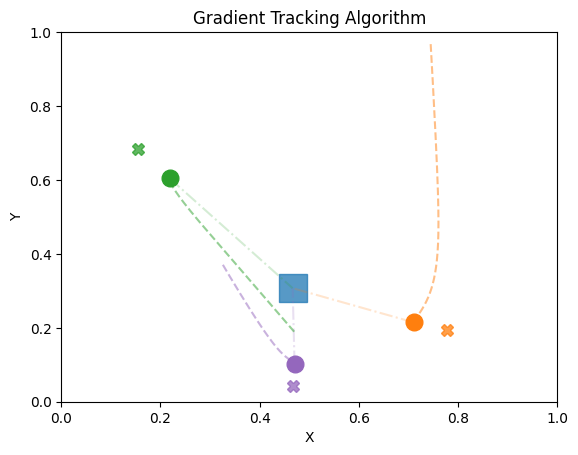

In [64]:
from IPython.display import HTML
# Create an animation, by showing the scenario at each iteration
def animate_scenario(z_history, private_targets, frames):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title("Gradient Tracking Algorithm")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # frames = range(0, 200, skip)

    def update(frame_idx):
        ax.clear()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title("Gradient Tracking Algorithm")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        plot_scenario(z_history[frames[frame_idx]], private_targets, z_history[:frames[frame_idx] + 1])
        return (ax,)

    ani = FuncAnimation(fig, update, frames=len(frames), blit=False, interval=200)

    # Fix: Display the animation
    display(HTML(ani.to_jshtml()))

    # Save the animation as a video file
    #ani.save("gradient_tracking_animation.mp4", fps=10, extra_args=["-vcodec", "libx264"])
    # plt.show()

animate_scenario(z_history, private_targets, frames=range(0, len(z_history), 100))